In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from io import BytesIO

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from joblib import Parallel, delayed

from google.cloud import bigquery

from data_collector import BQManager, GCP, Omie, MarginalPriceParams, OfferCurvesParams, OfferCurvesUnitsParams

## Upload tables to BigQuery

In [ ]:
job_config = bigquery.job.LoadJobConfig()
job_config.autodetect = True
job_config.create_disposition = bigquery.job.CreateDisposition.CREATE_IF_NEEDED
job_config.write_disposition = bigquery.job.WriteDisposition.WRITE_APPEND

years = range(2016, 2022)

for year in years:
    print("="*15  + f" {year} " + "="*15)
    Omie.upload_bq_year_file(omie_parameter=OfferCurvesUnitsParams, year=year, job_config=job_config)

In [ ]:
job_config = bigquery.job.LoadJobConfig()
job_config.autodetect = True
job_config.create_disposition = bigquery.job.CreateDisposition.CREATE_IF_NEEDED
job_config.write_disposition = bigquery.job.WriteDisposition.WRITE_APPEND


dates = pd.date_range(start="2021-01-01", end="2022-02-19", freq="D")
_ = Parallel(n_jobs=-1)(
    delayed(Omie.upload_bq_date_file)(omie_parameter=OfferCurvesParams, date=date, job_config=job_config)
    for date in dates
)

## Generate hourly tables

In [3]:
client = bigquery.Client(GCP.PROJECT_ID)
bq_manager = BQManager(client=client)

In [ ]:
bq_manager.generate_hourly_offer_curve_tables(curve_parameter=OfferCurvesUnitsParams, 
                                             offer_status=OfferCurvesUnitsParams.OfferStatus.offered)

## Download table

In [4]:
df = bq_manager.download_query_to_df(
    query=f"SELECT * FROM {GCP.BigQuery.Omie.DATASET_ID}.{GCP.BigQuery.Omie.OFFER_CURVES_UNITS_TABLE_ID}_{21}"
)

Downloading:   0%|          | 0/4358030 [00:00<?, ?rows/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4358030 entries, 0 to 4358029
Data columns (total 8 columns):
 #   Column      Dtype              
---  ------      -----              
 0   hour        int64              
 1   date        datetime64[ns, UTC]
 2   country     object             
 3   unit        object             
 4   offer_type  object             
 5   energy      float64            
 6   price       float64            
 7   status      object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 266.0+ MB


In [6]:
df_ask = df[df["offer_type"] == OfferCurvesUnitsParams.OfferType.ask.value]
df_bid = df[df["offer_type"] == OfferCurvesUnitsParams.OfferType.bid.value]

df_ask = df_ask.sort_values(["date", "price"])
df_bid = df_bid.sort_values("date").sort_values("price", ascending=False)

df_ask["agg_energy"] = df_ask.groupby("date")["energy"].transform("cumsum")
df_bid["agg_energy"] = df_bid.groupby("date")["energy"].transform("cumsum")

In [7]:
df_ask_date = df_ask.set_index("date")
df_bid_date = df_bid.set_index("date")

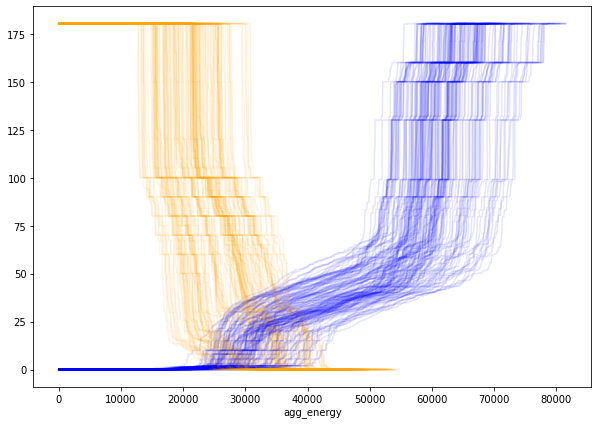

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
for date in pd.date_range(start="2020-01-01", end="2020-05-31", freq="D"):
    df_ask_date.loc[date].plot(x="agg_energy", y="price", ax=ax, label="", color="blue", alpha=0.1)
    df_bid_date.loc[date].plot(x="agg_energy", y="price", ax=ax, label="", color="orange", alpha=0.1)
legend = ax.get_legend()
legend.remove()

In [ ]:
%matplotlib tk

fig, ax = plt.subplots(figsize=(10, 7))

x_ask = df_ask_date.loc["2020-01-01"]["agg_energy"]
y_ask = df_ask_date.loc["2020-01-01"]["price"]
x_bid = df_bid_date.loc["2020-01-01"]["agg_energy"]
y_bid = df_bid_date.loc["2020-01-01"]["price"]
dates = pd.date_range(start="2020-01-01", end="2021-01-01", freq="D")
ask_curve, = ax.plot(x_ask, y_ask)
bid_curve, = ax.plot(x_bid, y_bid)


def animate(i):
    date = dates[i]
    
    ax.set_title(date.strftime("%Y-%m-%d"))
    ask_curve.set_xdata(df_ask_date.loc[date]["agg_energy"].values)
    ask_curve.set_ydata(df_ask_date.loc[date]["price"].values)
    bid_curve.set_xdata(df_bid_date.loc[date]["agg_energy"].values)
    bid_curve.set_ydata(df_bid_date.loc[date]["price"].values)
    
    
    return ask_curve, bid_curve


ani = animation.FuncAnimation(fig, animate, interval=80, blit=False, save_count=90)
#ani.save('curves.gif', writer='imagemagick', fps=10)
plt.show()

#### Find cleared price

In [9]:
df_ask_sample = df_ask_date.loc["2020-01-01"].reset_index()
df_bid_sample = df_bid_date.loc["2020-01-01"].reset_index()

In [10]:
ask_agg_energy = df_ask_sample["agg_energy"].values
bid_agg_energy = df_bid_sample["agg_energy"].values

In [11]:
agg_energy = np.unique(np.sort(np.concatenate([ask_agg_energy, bid_agg_energy])))

In [12]:
df_ask_sample = df_ask_sample.set_index("agg_energy").reindex(agg_energy)
df_bid_sample = df_bid_sample.set_index("agg_energy").reindex(agg_energy)

In [13]:
cols = ["offer_type", "price"]
df_ask_sample = df_ask_sample[cols]
df_bid_sample = df_bid_sample[cols]
df_price = df_ask_sample.merge(df_bid_sample, left_index=True, right_index=True)

In [14]:
df_price["last_ask"] = df_price["price_x"].fillna(method="ffill")
df_price["last_bid"] = df_price["price_y"].fillna(method="ffill")

In [15]:
df_price["curve_intersection"] = df_price["last_bid"] <= df_price["last_ask"]
df_price.reset_index(inplace=True)

In [16]:
cleared_price = df_price[df_price["curve_intersection"]].iloc[0]
cleared_price

agg_energy            27234.5
offer_type_x              NaN
price_x                   NaN
offer_type_y                C
price_y                  20.0
last_ask                 20.3
last_bid                 20.0
curve_intersection       True
Name: 1175, dtype: object

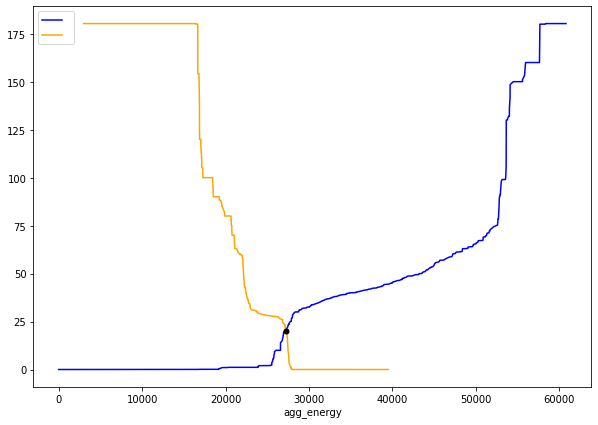

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
for date in pd.date_range(start="2020-01-01", end="2020-01-01", freq="D"):
    df_ask_date.loc[date].plot(x="agg_energy", y="price", ax=ax, label="", color="blue", alpha=1)
    df_bid_date.loc[date].plot(x="agg_energy", y="price", ax=ax, label="", color="orange", alpha=1)
    ax.plot(cleared_price["agg_energy"], cleared_price["last_ask"], marker="o", color="black", markersize=5)

In [18]:
def obtain_cleared_price(df_ask: pd.DataFrame, df_bid: pd.DataFrame, date: pd.Timestamp) -> pd.Series:
    df_ask = df_ask.loc[date].reset_index()
    df_bid = df_bid.loc[date].reset_index()
    
    ask_agg_energy = df_ask["agg_energy"].values
    bid_agg_energy = df_bid["agg_energy"].values
    agg_energy = np.unique(np.sort(np.concatenate([ask_agg_energy, bid_agg_energy])))
    
    df_ask = df_ask.set_index("agg_energy").reindex(agg_energy)
    df_bid = df_bid.set_index("agg_energy").reindex(agg_energy)
    
    cols = ["offer_type", "price"]
    df_ask = df_ask[cols]
    df_bid = df_bid[cols]
    df_price = df_ask.merge(df_bid, left_index=True, right_index=True, suffixes=("_ask", "_bid"))
    
    df_price["last_ask"] = df_price["price_ask"].fillna(method="ffill")
    df_price["last_bid"] = df_price["price_bid"].fillna(method="ffill")
    
    df_price["curve_intersection"] = df_price["last_bid"] <= df_price["last_ask"]
    df_price.reset_index(inplace=True)
    
    cleared_price = df_price[df_price["curve_intersection"]].iloc[0]
    cleared_price = cleared_price.rename({"last_ask": "price"})[["agg_energy", "price"]] 
    cleared_price.name = date
    return cleared_price

In [19]:
dates = pd.date_range(start="2016-01-01", end="2021-10-31", freq="D")
series = []
for date in dates:
    series.append(obtain_cleared_price(df_ask=df_ask_date, df_bid=df_bid_date, date=date))

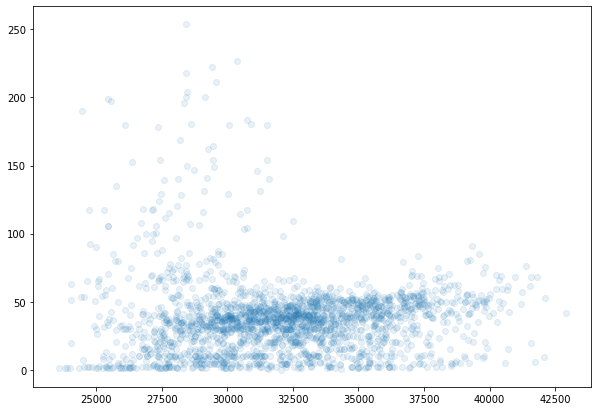

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
price_series = pd.concat(series, axis=1).T
ax.scatter(x=price_series["agg_energy"], y=price_series["price"], marker="o", alpha=0.1)

In [21]:
price_series.head()

,agg_energy,price
2016-01-01,28911.6,4.0
2016-01-02,28770.7,25.0
2016-01-03,31112.0,3.19
2016-01-04,32966.9,11.3
2016-01-05,33259.2,11.0


In [22]:
%matplotlib tk
fig, ax = plt.subplots(figsize=(10, 7))

dates = pd.date_range(start="2020-01-01", end="2021-10-31", freq="D")
first_date = dates[0]
initial_point = price_series.loc[first_date]
price_points, = ax.plot(initial_point["agg_energy"], initial_point["price"], 
                        color="blue", marker="o", ls="-", alpha=0.1)
ax.set_xlim(24_000, 42_500)
ax.set_ylim(-5, 250)
ax.set_xlabel("Energy [MWh]")
ax.set_ylabel("Price [€/MWh]")


def animate(i):
    date = dates[i]
    prices = price_series.loc[first_date:date]
    
    ax.set_title(date.strftime("%Y-%m-%d"))
    price_points.set_xdata(prices["agg_energy"].values)
    price_points.set_ydata(prices["price"].values)
    
    return price_points,


ani = animation.FuncAnimation(fig, animate, interval=120, blit=False, save_count=len(dates))
FFwriter = animation.FFMpegWriter(fps=20)
ani.save('energy_price_evolution_hour_21_2020_2021.mp4', writer = FFwriter)
plt.show()

2022-02-21 10:32:39,530|matplotlib.animation|INFO|Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-02-21 10:32:39,531|matplotlib.animation|INFO|MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x700 -pix_fmt rgba -r 20 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y energy_price_evolution_hour_21_2020_2021.mp4
